In [1]:
import common_datasets.binary_classification as binclas
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import wilcoxon

In [2]:
def generate_random_classifier(random_state):
    mode = random_state.randint(4)
    if mode == 0:
        classifier = RandomForestClassifier
        params = {'max_depth': random_state.randint(3, 10),
                  'random_state': 5}
    if mode == 1:
        classifier = DecisionTreeClassifier
        params = {'max_depth': random_state.randint(3, 10),
                  'random_state': 5}
    if mode == 2:
        classifier = SVC
        params = {'probability': True, 'C': random_state.rand()*2 + 0.001}
    if mode == 3:
        classifier = KNeighborsClassifier
        params = {'n_neighbors': random_state.randint(1, 10)}
    
    return (classifier, params)

In [3]:
datasets = binclas.get_filtered_data_loaders(n_col_bounds=(0, 50), n_bounds=(0, 2000), n_minority_bounds=(20, 1000), n_from_phenotypes=1, imbalance_ratio_bounds=(0.2, 20.0))

In [4]:
len(datasets)

28

In [5]:
names = [dataset()['name'] for dataset in datasets if not dataset()['name'].startswith('led')]

In [6]:
from common_datasets.binary_classification import summary_pdf

In [7]:
tmp = summary_pdf[summary_pdf['name'].isin(names)].reset_index(drop=True)
tmp = tmp[['name', 'n_col', 'n', 'n_minority', 'imbalance_ratio', 'citation_key']]
tmp['name_key'] = tmp.apply(lambda row: f'{row["name"]} \\cite{{{row["citation_key"]}}}', axis=1)
tmp = tmp[['name_key', 'n', 'n_col', 'n_minority', 'imbalance_ratio']]
tmp.columns = ['name', 'size', 'attr.', 'p', 'imb. ratio']
tmp['n'] = tmp['size'] - tmp['p']
tmp = tmp[['name', 'size', 'attr.', 'p', 'n', 'imb. ratio']]

In [8]:
tmp.index = [idx for idx in range(1, 28)]
print(tmp.to_latex(float_format="%.2f").replace('_', ' '))

\begin{tabular}{llrrrrr}
\toprule
 & name & size & attr. & p & n & imb. ratio \\
\midrule
1 & abalone9 18 \cite{keel} & 731 & 9 & 42 & 689 & 16.40 \\
2 & appendicitis \cite{keel} & 106 & 7 & 21 & 85 & 4.05 \\
3 & australian \cite{keel} & 690 & 16 & 307 & 383 & 1.25 \\
4 & bupa \cite{keel} & 345 & 6 & 145 & 200 & 1.38 \\
5 & CM1 \cite{krnn} & 498 & 21 & 49 & 449 & 9.16 \\
6 & crx \cite{keel} & 653 & 37 & 296 & 357 & 1.21 \\
7 & dermatology-6 \cite{keel} & 358 & 34 & 20 & 338 & 16.90 \\
8 & ecoli1 \cite{keel} & 336 & 7 & 77 & 259 & 3.36 \\
9 & glass0 \cite{keel} & 214 & 9 & 70 & 144 & 2.06 \\
10 & haberman \cite{keel} & 306 & 3 & 81 & 225 & 2.78 \\
11 & hepatitis \cite{krnn} & 155 & 19 & 32 & 123 & 3.84 \\
12 & ionosphere \cite{keel} & 351 & 33 & 126 & 225 & 1.79 \\
13 & iris0 \cite{keel} & 150 & 4 & 50 & 100 & 2.00 \\
14 & mammographic \cite{keel} & 830 & 5 & 403 & 427 & 1.06 \\
15 & monk-2 \cite{keel} & 432 & 6 & 204 & 228 & 1.12 \\
16 & new thyroid1 \cite{keel} & 215 & 5 & 35 & 180 & 

In [9]:
results = []
random_state = np.random.RandomState(5)
dropped = 0

while len(results) < 10_000:
    loader = random_state.choice(datasets)
    dataset = loader()
    X = dataset['data']
    y = dataset['target']
    name = dataset['name']

    p_total = np.sum(y)
    n_total = len(y) - p_total

    k = random_state.randint(2, 11)
    while k > np.sum(y):
        k = random_state.randint(2, 11)
    
    threshold = None

    accs = []
    senss = []
    specs = []
    aucs = []

    labels = []
    preds = []

    classifier = generate_random_classifier(random_state)

    classifier_obj = classifier[0](**classifier[1])
    
    for train, test in StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state).split(X, y):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]

        classifier_obj.fit(X_train, y_train)

        y_pred = classifier_obj.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred)

        if threshold is None:
            threshold = random_state.choice(y_pred)
        threshold = np.sum(y_train)/len(y_train)

        tp = np.sum((y_pred >= threshold) & (y_test == 1))
        tn = np.sum((y_pred < threshold) & (y_test == 0))
        p = np.sum(y_test)
        n = len(y_test) - np.sum(y_test)

        acc = (tp + tn) / (p + n)
        sens = (tp) / (p)
        spec = (tn) / (n)

        accs.append(acc)
        senss.append(sens)
        specs.append(spec)
        aucs.append(auc)

        labels.append(y_test)
        preds.append(y_pred)
    
    if np.mean(aucs) < 0.5:
        dropped += 1
        continue

    best_th = -1
    best_acc = 0
    for th in np.unique(np.hstack(preds)).tolist() + [np.inf, -np.inf]:
        tmp_accs = []
        for y_pred, y_test in zip(preds, labels):
            tp = np.sum((y_pred >= th) & (y_test == 1))
            tn = np.sum((y_pred < th) & (y_test == 0))

            tmp_accs.append((tp + tn) / len(y_test))

        #print(th, np.mean(tmp_accs), best_acc)

        if np.mean(tmp_accs) > best_acc:
            best_acc = np.mean(tmp_accs)
            best_th = th

    best_accs = []
    best_senss = []
    best_specs = []

    for y_pred, y_test in zip(preds, labels):
        tp = np.sum((y_pred >= best_th) & (y_test == 1))
        tn = np.sum((y_pred < best_th) & (y_test == 0))
        p = np.sum(y_test)
        n = len(y_test) - np.sum(y_test)

        best_accs.append((tp + tn) / len(y_test))
        best_senss.append((tp) / (p))
        best_specs.append((tn) / (n))

    acc = np.mean(accs)
    sens = np.mean(senss)
    spec = np.mean(specs)
    auc = np.mean(aucs)
    best_acc2 = np.mean(best_accs)
    best_sens = np.mean(best_senss)
    best_spec = np.mean(best_specs)

    results.append((name, k, acc, sens, spec, auc, best_acc2, best_sens, best_spec, threshold, best_th, best_acc, p_total, n_total))


In [10]:
dropped

202

In [11]:
data = pd.DataFrame(results, columns=[
    'dataset', 'k', 'acc', 'sens', 'spec', 'auc', 'best_acc', 'best_sens', 'best_spec', 'threshold', 'best_threshold', 'best_acc_orig', 'p', 'n'])

In [12]:
data.head()

,dataset,k,acc,sens,spec,auc,best_acc,best_sens,best_spec,threshold,best_threshold,best_acc_orig,p,n
0,bupa,8,0.695560,0.663377,0.720000,0.751001,0.730510,0.580409,0.840000,0.420530,0.508864,0.730510,145,200
1,new_thyroid1,4,0.925577,1.000000,0.911111,0.994483,0.962788,0.888889,0.977778,0.166667,0.333333,0.962788,35,180
2,haberman,3,0.653595,0.617284,0.666667,0.699095,0.738562,0.012346,1.000000,0.264706,0.885074,0.738562,81,225
3,dermatology-6,2,0.966480,0.950000,0.967456,0.970710,0.980447,0.850000,0.988166,0.055866,0.750000,0.980447,20,338
4,monk-2,3,0.974537,1.000000,0.951754,1.000000,0.979167,1.000000,0.960526,0.472222,0.595344,0.979167,204,228


In [13]:
data.to_csv('raw-aggregated3.csv')

In [14]:
data.head()

,dataset,k,acc,sens,spec,auc,best_acc,best_sens,best_spec,threshold,best_threshold,best_acc_orig,p,n
0,bupa,8,0.695560,0.663377,0.720000,0.751001,0.730510,0.580409,0.840000,0.420530,0.508864,0.730510,145,200
1,new_thyroid1,4,0.925577,1.000000,0.911111,0.994483,0.962788,0.888889,0.977778,0.166667,0.333333,0.962788,35,180
2,haberman,3,0.653595,0.617284,0.666667,0.699095,0.738562,0.012346,1.000000,0.264706,0.885074,0.738562,81,225
3,dermatology-6,2,0.966480,0.950000,0.967456,0.970710,0.980447,0.850000,0.988166,0.055866,0.750000,0.980447,20,338
4,monk-2,3,0.974537,1.000000,0.951754,1.000000,0.979167,1.000000,0.960526,0.472222,0.595344,0.979167,204,228


In [15]:
data['width'] = data.apply(lambda row: None if row['auc_int'] is None else row['auc_int'][1] - row['auc_int'][0], axis=1)
data['half_width'] = data['width'] / 2
data['label'] = data['lower'] + '-' + data['upper']

KeyError: 'auc_int'

In [90]:
import matplotlib.pyplot as plt

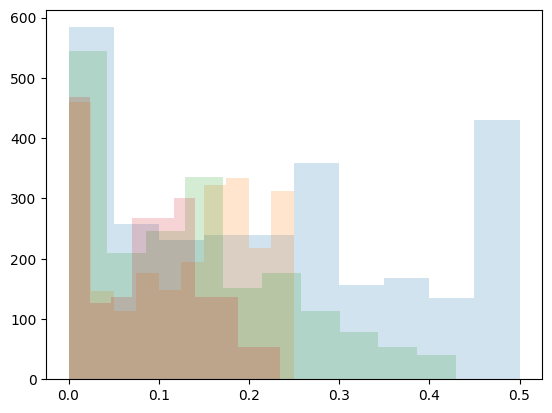

In [77]:
for label in ['min-max', 'cmin-max', 'min-amax', 'cmin-amax']:
    tmp = data[data['label'] == label]
    plt.hist(tmp['half_width'], label=label, alpha=0.2)

,auc,acc,sens,spec,threshold,auc_int,auc,lower,upper,width,half_width,label
0,0.599940,0.9728,0.2000,1.0000,0.363737,"(0.19988001000000002, 1.0)",0.599940,min,max,0.800120,0.400060,min-max
1,0.594352,0.9728,0.2000,1.0000,0.363737,"(0.19988001000000002, 0.9888240382464789)",0.594352,min,amax,0.788944,0.394472,min-amax
2,0.759980,0.9728,0.2000,1.0000,0.363737,"(0.51996002, 1.0)",0.759980,cmin,max,0.480040,0.240020,cmin-max
3,0.754392,0.9728,0.2000,1.0000,0.363737,"(0.51996002, 0.9888240382464789)",0.754392,cmin,amax,0.468864,0.234432,cmin-amax
4,0.638872,0.7273,0.5000,0.7778,0.089821,"(0.38877223000000005, 0.88897221)",0.638872,min,max,0.500200,0.250100,min-max
...,...,...,...,...,...,...,...,...,...,...,...,...
11195,0.966989,0.9708,0.9556,0.9783,0.263535,"(0.935897845, 0.9980804617282608)",0.966989,cmin,amax,0.062183,0.031091,cmin-amax
11196,0.653119,0.7475,0.4253,0.8810,0.527623,"(0.37455868000000003, 0.93168006)",0.653119,min,max,0.557121,0.278561,min-max
11197,0.610385,0.7475,0.4253,0.8810,0.527623,"(0.37455868000000003, 0.8462117847881774)",0.610385,min,amax,0.471653,0.235827,min-amax
11198,0.739264,0.7475,0.4253,0.8810,0.527623,"(0.546848605, 0.93168006)",0.739264,cmin,max,0.384831,0.192416,cmin-max


In [102]:
tmp = data[data['auc1'].notnull()]

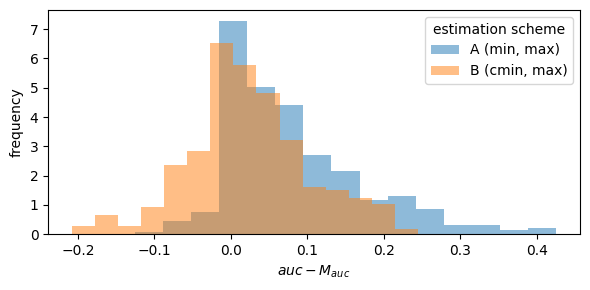

In [103]:
plt.figure(figsize=(6, 3))

plt.hist(tmp['auc'] - tmp['auc0'], density=True, label='A (min, max)', alpha=0.5, bins=15)
plt.hist(tmp['auc'] - tmp['auc1'], density=True, label='B (cmin, max)', alpha=0.5, bins=15)

plt.xlabel(r'$auc - M_{auc}$')
plt.ylabel('frequency')

plt.legend(title='estimation scheme')

plt.tight_layout()
plt.savefig('hist0.png')
plt.show()

In [104]:
np.mean(np.abs((tmp['auc'] - tmp['auc0']))), np.mean(np.abs((tmp['auc'] - tmp['auc1']))),

(np.float64(0.08636092494811481), np.float64(0.060940201466227896))

In [105]:
wilcoxon(np.abs((tmp['auc'] - tmp['auc0'])).values, np.abs((tmp['auc'] - tmp['auc1'])).values)

WilcoxonResult(statistic=np.float64(14620.0), pvalue=np.float64(7.452719583839613e-18))